<h2>Three-Dimensional Field Example: Isobaric Fields</h2>

These fields are somewhat more complex to plot because they require interpolation from the model's vertical grid to a user-specified vertical grid (here, an isobaric level). The example below plots the 500 hPa height (m), wind speed (kt), and horizontal wind (barbs; standard meteorological convention) forecast valid at 0000 UTC 8 October 2016 from the Assignment 1 Hurricane Matthew tutorial case.

This example was drawn from the wrf-python Plotting Examples gallery (https://wrf-python.readthedocs.io/en/latest/plot.html) with only minor tweaks. More information on how to use wrf-python is available at https://wrf-python.readthedocs.io/en/main/basic_usage.html.

<hr>

We start by loading the necessary modules. These are drawn from five packages - netCDF4, numpy, matplotlib, cartopy, and wrf (short for wrf-python).

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.ticker as mticker
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from wrf import (getvar, interplevel, to_np, latlon_coords, get_cartopy,
                 cartopy_xlim, cartopy_ylim)

Next, we open the wrfout file as a netcdf4 Dataset. Note that this file contains data from only a single output time.

In [2]:
ncfile = Dataset("wrfout_d01_2016-10-08_00:00:00")

Extract the pressure, geopotential height, and wind variables from the wrfout file. All variables in this example are drawn from the list at https://wrf-python.readthedocs.io/en/latest/user_api/generated/wrf.getvar.html; you can also tell it to extract any variable from the wrfout file by passing it the desired variable's name.

In [3]:
p = getvar(ncfile, "pressure")
z = getvar(ncfile, "z", units="m")
ua = getvar(ncfile, "ua", units="kt")
va = getvar(ncfile, "va", units="kt")
wspd = getvar(ncfile, "wspd_wdir", units="kts")[0,:]

The pressure variable obtained above is used to interpolate the other variables to a specified isobaric surface - here being 500 hPa. You could instead get potential temperature and interpolate to a specified isentropic surface or use the height field to interpolate to a specified height surface.

In [4]:
ht_500 = interplevel(z, p, 500)
u_500 = interplevel(ua, p, 500)
v_500 = interplevel(va, p, 500)
wspd_500 = interplevel(wspd, p, 500)

Next, we get the latitude and longitude points, as defined by the ht_500 variable. We then use call the get_cartopy helper function to extract out the data's map projection. Since all of the variables have the same lat/lon points and map projections after interpolating to the 500 hPa surface, any variable could be used in place of ht_500 in these commands.

In [5]:
lats, lons = latlon_coords(ht_500)
cart_proj = get_cartopy(ht_500)

The remainder of the plot-generation code is contained in a single code block below. This is due to a Python quirk; a map-based figure is generated before we add any data to it if we try to break the code up into separate code blocks. Please see the comment blocks below to interpret the code.

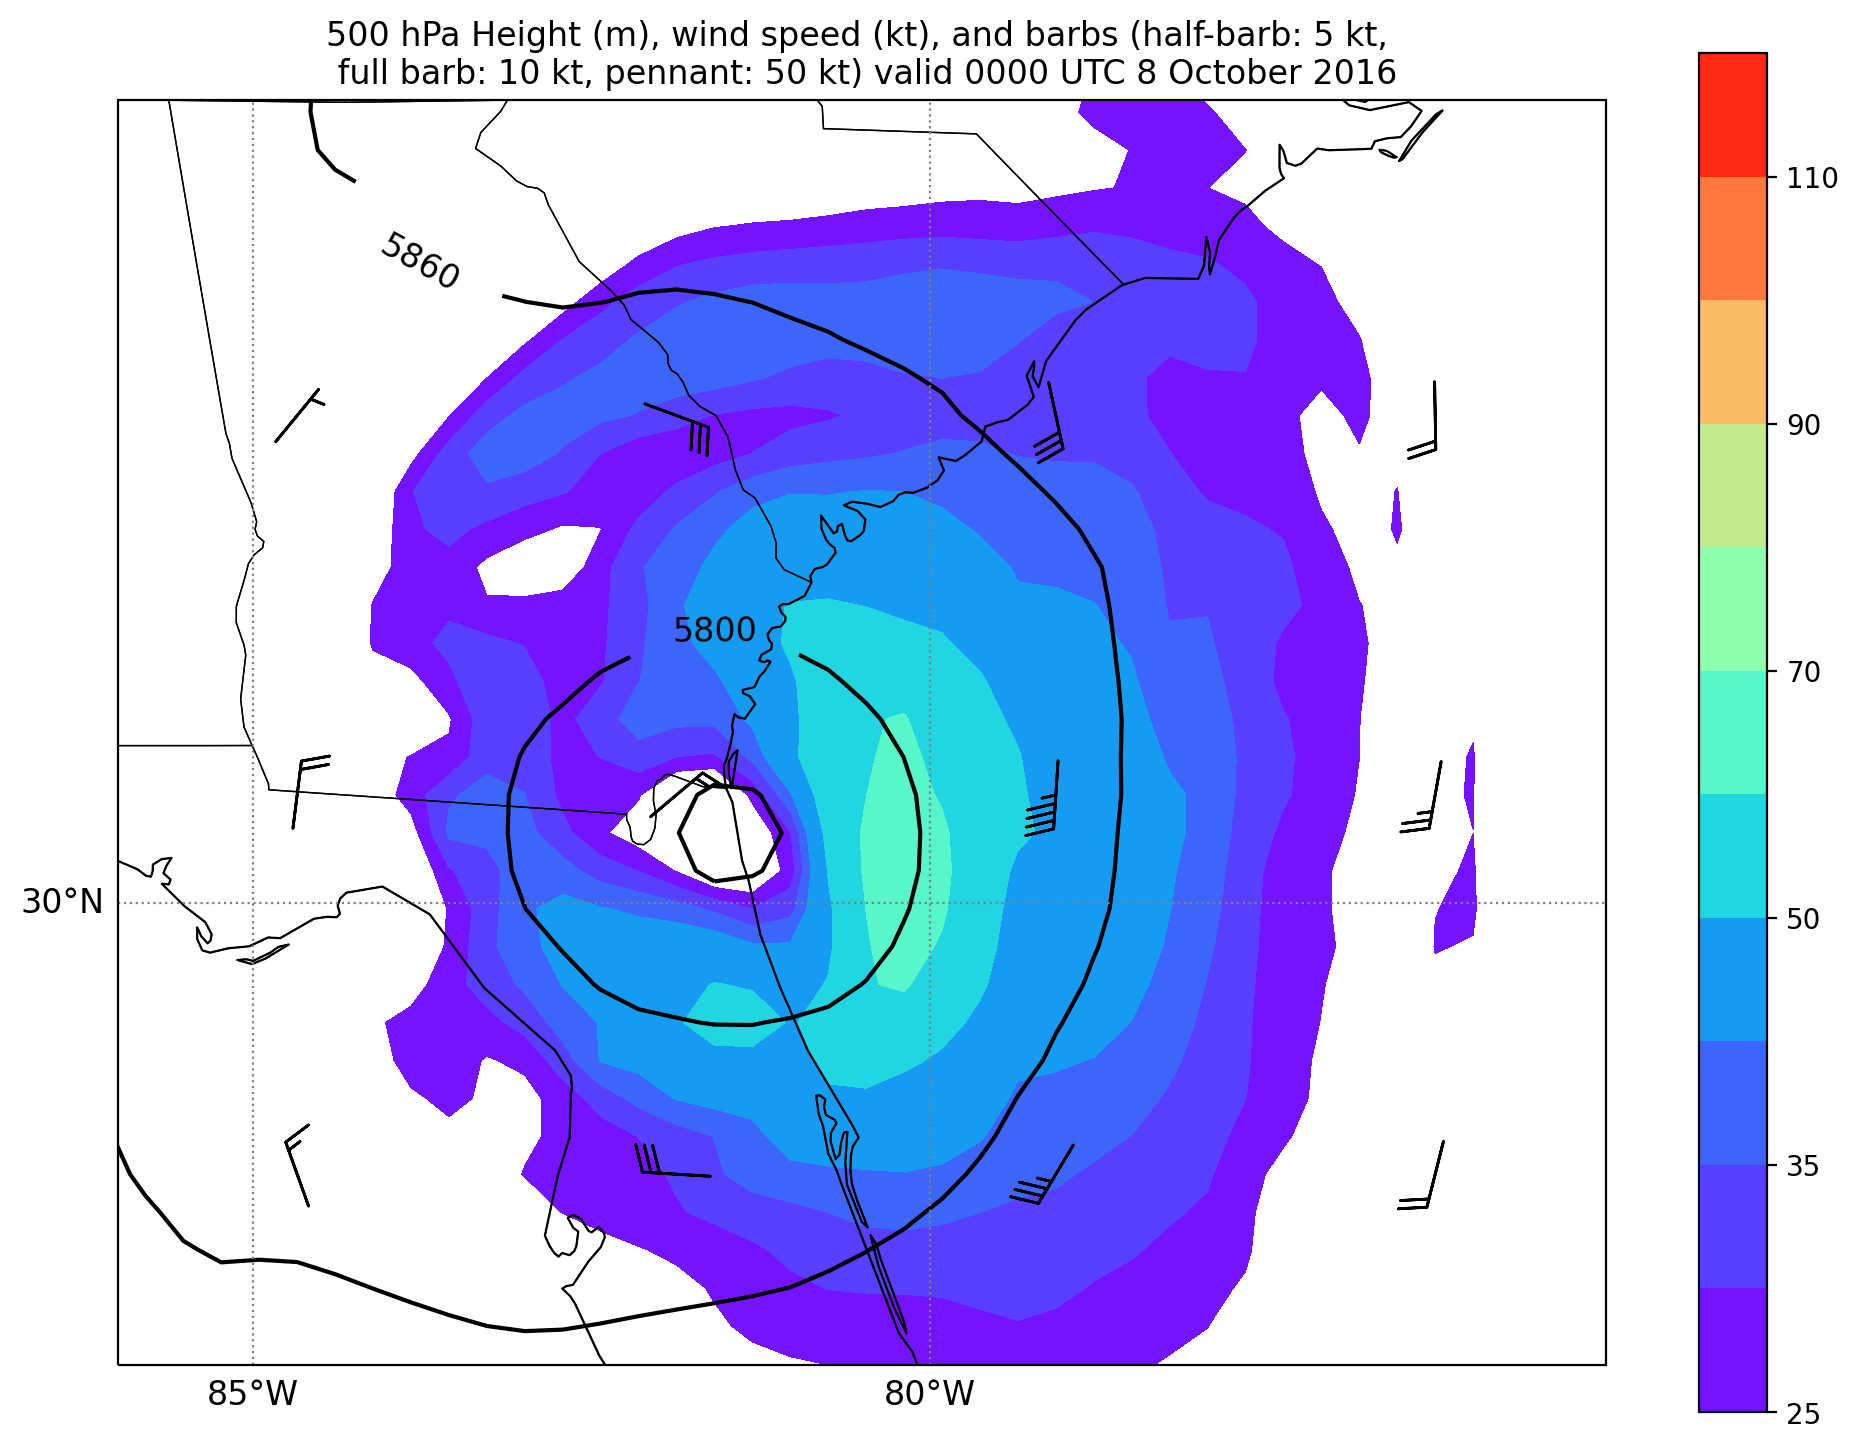

In [6]:
# Create a figure instance (12" wide by 9" tall at 200 dots per inch)
# then create a set of georeferenced axes for the figure.
fig = plt.figure(figsize=(12,9), dpi=200.)
ax = plt.axes(projection=cart_proj)

# Add state borders and coastlines.
# These commands automatically download the needed
# data if they have not previously been downloaded.
states = cfeature.NaturalEarthFeature(category="cultural", scale="50m",
                                      facecolor="none",
                                      name="admin_1_states_provinces")
ax.add_feature(states, linewidth=0.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)

# Add the 500 hPa geopotential height contours. We first
# specify the levels to plot - 5200 m (inclusive) to 6000 m
# (exclusive) by 60 m. The contours are plotted as solid
# black lines on a map with the desired map projection
# (here, the PlateCarree projection). We also add contour
# labels so we know what contour has what value.
levels = np.arange(5200., 6000., 60.)
contours = plt.contour(to_np(lons), to_np(lats), to_np(ht_500),
                       levels=levels, colors="black",
                       transform=crs.PlateCarree())
plt.clabel(contours, inline=1, fontsize=12, fmt="%i")

# Add shaded 500 hPa wind speed (in kt, as defined
# when we first extracted the variable). We first
# specify the levels to plot - 25-40 kt by 5 kt,
# then 40-120 kt by 10 kt - then plot the filled
# contours using the matplotlib rainbow colormap,
# then add a colorbar (which Python will place on
# the right-hand side of the plot by default).
# More info on colormaps:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
levels = [25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 120]
wspd_contours = plt.contourf(to_np(lons), to_np(lats), to_np(wspd_500),
                             levels=levels,
                             cmap=get_cmap("rainbow"),
                             transform=crs.PlateCarree())
plt.colorbar(wspd_contours, ax=ax, pad=.05)

# Add the 500 hPa wind barbs. The :::10,::10 arguments on
# each variable are a method of only plotting every 10th
# data point in the x- and y-directions. The first two ::
# lacking numbers mean all data points in that direction;
# the 10 following the :: means every 10th point in that
# direction. The pivot argument tells Python to plot the
# barbs centered on that model grid point.
plt.barbs(to_np(lons[::10,::10]), to_np(lats[::10,::10]),
          to_np(u_500[::10, ::10]), to_np(v_500[::10, ::10]),
          transform=crs.PlateCarree(), pivot='middle', length=7)

# This code block sets the map's bounds. There are two options.
# In the first - the two commented set_xlim and set_ylim lines - 
# the map's bounds are set to the domain's extent, as determined
# using the wrf-python cartopy_x/ylim helper functions.
# In the second - currently active - the map's bounds are set to
# a user-specified range, with the desired map projection (must
# must that used in the plotting arguments above) passed at the end.
#ax.set_xlim(cartopy_xlim(ht_500))
#ax.set_ylim(cartopy_ylim(ht_500))
ax.set_extent([-86.,-75.,27.,35.],crs=crs.PlateCarree())

# Add latitude/longitude gridlines.
# The first line sets up basic gridline parameters - grey dotted lines with labels.
# The next two lines suppress drawing labels on the top and right sides of the plot,
#    making the plot's labels consistent with typical map conventions.
# The next two lines specify how frequently to draw gridlines - here, every
#    5 deg lat/lon. It may be best to comment these two lines out the first
#    time you run the code to see the plot's overall extent, then determine
#    how frequently you wish to draw the gridlines in each direction.
# The next two lines control aspects of labeling the gridlines, here their
#    font size and text color.
# Lastly, the final two lines format the gridline numbers in deg N/S/E/W format.
# More information: https://scitools.org.uk/cartopy/docs/latest/matplotlib/gridliner.html
gridlines = ax.gridlines(color="grey", linestyle="dotted", draw_labels=True)
gridlines.top_labels = False
gridlines.right_labels = False
gridlines.xlocator = mticker.FixedLocator(np.arange(-90.,-55.,5.))
gridlines.ylocator = mticker.FixedLocator(np.arange(15.,45.,5.))
gridlines.xlabel_style = {'size':12, 'color':'black'}
gridlines.ylabel_style = {'size':12, 'color':'black'}
gridlines.xformatter = LONGITUDE_FORMATTER
gridlines.yformatter = LATITUDE_FORMATTER

# Add a plot title and then show the image. Because we have
# a long title, we use the \n newline character about midway
# to split the title across two lines.
plt.title("500 hPa Height (m), wind speed (kt), and barbs (half-barb: 5 kt, \n full barb: 10 kt, pennant: 50 kt) valid 0000 UTC 8 October 2016")
plt.show()